In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/Junnarkar16/Text-Generation.git
%cd Text-Generation
from install import *
install_requirements()

Cloning into 'Text-Generation'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (19/19), 9.63 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Text-Generation
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
# hide
from utils import *
# setup_chapter()

# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

## Greedy Search Decoding

In [ ]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# hide_output
import pandas as pd

input_txt = "An apple a day"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,An apple a day,keeps (78.10%),", (2.39%)",is (1.86%),may (1.47%),helps (1.24%)
1,An apple a day keeps,the (98.76%),a (0.16%),The (0.15%),your (0.06%),on (0.05%)
2,An apple a day keeps the,doctor (85.99%),Doctor (1.32%),dentist (1.03%),doctors (0.49%),cancer (0.43%)
3,An apple a day keeps the doctor,away (99.51%),Away (0.23%),from (0.05%),out (0.04%),off (0.04%)
4,An apple a day keeps the doctor away,"."" (19.39%)",""" (12.70%)",. (12.51%),", (6.61%)",: (5.46%)
5,"An apple a day keeps the doctor away.""",\n (38.47%),\n\n (2.89%),The (2.83%),<|endoftext|> (2.42%),— (2.33%)
6,"An apple a day keeps the doctor away.""\n",\n (99.16%),The (0.08%),""" (0.06%)",I (0.04%),In (0.02%)
7,"An apple a day keeps the doctor away.""\n\n",The (6.96%),""" (4.91%)",I (2.63%),In (2.47%),This (2.19%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


An apple a day keeps the doctor away."

The


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

log-prob: -55.23


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

log-prob: -93.12


## Sampling Methods

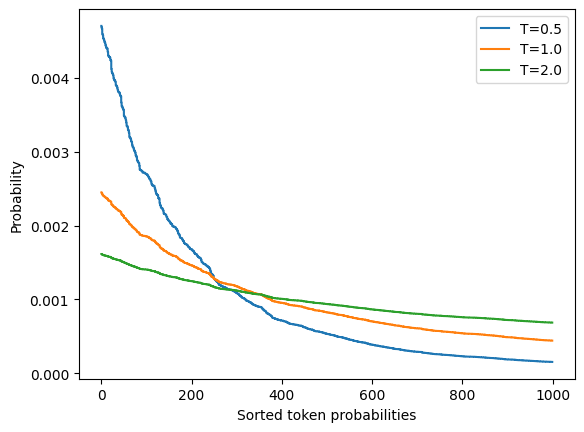

In [ ]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Banglington station line protagonist Bree Miller woke nostalgiate Rider Faithrometta Bluial Mju Agreement generously brings Kashun Dracozin Auctuz Doraelque Pumpkin meremavern stall class inequariansiamond disse * Runew Endurance whilst spear secured majorityb zo coachinginventoryatelletonwarming instinctivelypres Wrestling chargesThingsCooldown Guillard Ty physicianness Kimvillecurrently exhaustionSince at aff da temporacia MD RIPAbout iter


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists were searching for the source of the mysterious sound, which was making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a tiger,' said Luis Guzman, a researcher from the University of Buenos Aires, Argentina.


'But when


## Top-k and Nucleus Sampling

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

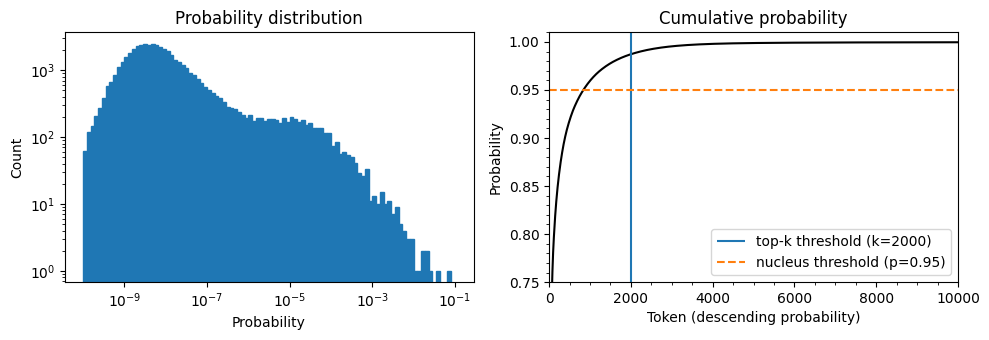

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire Naturelle)

The researchers came across about 50 of the animals in the valley. They had lived in such a remote and isolated area at that location for nearly a thousand years that


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists studied the DNA of the animals and came to the conclusion that the herd are descendants of a domesticated horse called the Auroch. The researchers believe that the Auroch may have originally lived in the Andes and later migrated to the United States.


The animals were found in an area of the valley called the Las Pajas or 'Mounts of the Sky'.



